<a href="https://colab.research.google.com/github/JaySingh79/Cross-Lingual-Arabizi-Sentiment-Modeling-on-Tensor-Processing-Units-/blob/main/Cross_Lingual_Arabizi_Sentiment_Modeling_on_Tensor_Processing_Units.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import logging
from tensorflow.keras.layers import (
Dense,
Flatten,
Conv1D,
Dropout,
Input,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from transformers import BertTokenizer, TFBertModel
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
import re
import random

In [5]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
  strategy = tf.distribute.get_strategy() # for CPU and single
  print('Number of replicas:', strategy.num_replicas_in_sync)

In [6]:
max_length = 140
batch_size = 16
dev_size = 0.1
num_class = 4

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [7]:
train_df = pd.read_csv('/content/Arabizi-Dailect-Train.csv')
train_df.text = train_df.text.astype(str)
train_df.drop_duplicates(subset=['text'],inplace=True)
train_df.label=train_df.label.map({-1:0,1:2,0:1})
train, dev = train_test_split(train_df, test_size=dev_size, random_state=42)

In [8]:
def bert_encode(data):
  tokens = tokenizer.batch_encode_plus(
  data, max_length=max_length, padding="max_length", truncation=True
  )
  return tf.constant(tokens["input_ids"])
train_encoded = bert_encode(train.text)
dev_encoded = bert_encode(dev.text)
train_labels = tf.keras.utils.to_categorical(train.label.values, num_classes=num_class)
dev_labels = tf.keras.utils.to_categorical(dev.label.values, num_classes=num_class)
train_dataset = (
tf.data.Dataset.from_tensor_slices((train_encoded, train_labels))
.shuffle(100)
.batch(batch_size)
).cache()
dev_dataset = (
tf.data.Dataset.from_tensor_slices((dev_encoded, dev_labels))
.shuffle(100)
.batch(batch_size)
).cache()


In [9]:
def bert_tweets_model():
  bert_encoder = TFBertModel.from_pretrained(model_name, output_attentions=True)
  input_word_ids = Input(
  shape=(max_length,), dtype=tf.int32, name="input_ids"
  )
  last_hidden_states = bert_encoder(input_word_ids)[0]
  clf_output = Flatten()(last_hidden_states)
  net = Dense(512, activation="relu")(clf_output)
  net = Dropout(0.3)(net)
  net = Dense(440, activation="relu")(net)
  net = Dropout(0.3)(net)
  output = Dense(num_class, activation="softplus")(net)
  model = Model(inputs=input_word_ids, outputs=output)
  return model

In [10]:
with strategy.scope():
  model = bert_tweets_model()
  adam_optimizer = Adam(learning_rate=1e-5)
  model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
  model.summary()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 140)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  177853440
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             140, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=((None, 12, None,             
                             140),                               
                              (None, 12, None, 140),         

In [11]:
history = model.fit(
train_dataset,
batch_size=batch_size,
epochs=5,
validation_data=dev_dataset,
verbose=1,
)

Epoch 1/5


4166/4166 [==============================] - 532s 106ms/step - loss: 0.6515 - accuracy: 0.7136 - val_loss: 0.5304 - val_accuracy: 0.7650
Epoch 2/5
4166/4166 [==============================] - 432s 104ms/step - loss: 0.4979 - accuracy: 0.7945 - val_loss: 0.4806 - val_accuracy: 0.7946
Epoch 3/5
4166/4166 [==============================] - 433s 104ms/step - loss: 0.4196 - accuracy: 0.8306 - val_loss: 0.4900 - val_accuracy: 0.8058
Epoch 4/5
4166/4166 [==============================] - 432s 104ms/step - loss: 0.3524 - accuracy: 0.8612 - val_loss: 0.5075 - val_accuracy: 0.8111
Epoch 5/5
4166/4166 [==============================] - 432s 104ms/step - loss: 0.2888 - accuracy: 0.8899 - val_loss: 0.5530 - val_accuracy: 0.8104


In [12]:
model.save_weights('weights.h5', overwrite=True)

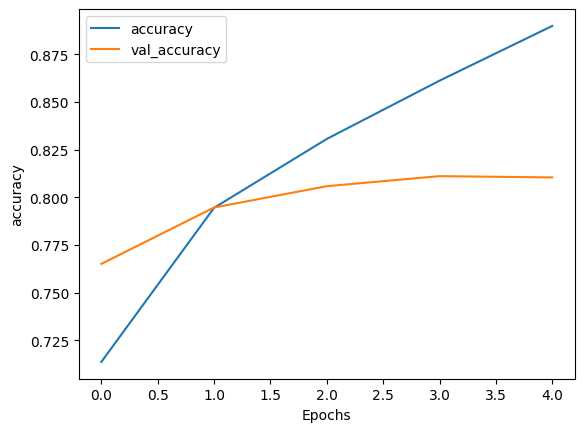

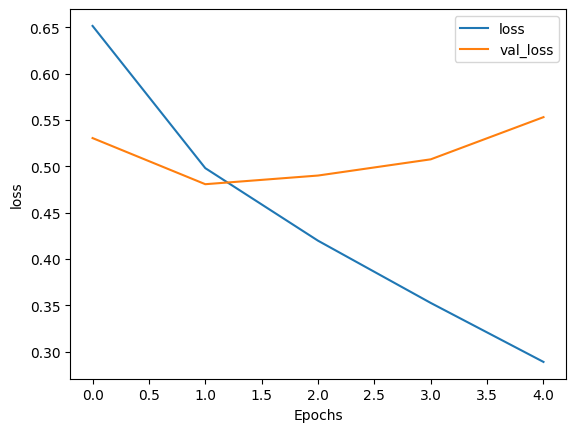

In [15]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history["val_" + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, "val_" + string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
test = pd.read_csv('/content/Test.csv')
test.text = test.text.astype(str)
test_encoded = bert_encode(test.text)

test_dataset = tf.data.Dataset.from_tensor_slices(test_encoded).batch(batch_size)

predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = np.argmax(predicted_tweets, axis=-1)

1875/1875 [==============================] - 47s 22ms/step


In [21]:
final_results = pd.DataFrame({"ID": test.ID, "label": predicted_tweets_binary})
final_results.label = final_results.label.map({1:-1, 3:1, 2:0})
final_results.label.value_counts()


 0.0    14512
-1.0      872
Name: label, dtype: int64